In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

In [2]:
df_dataset = pd.read_csv("2019_SCADA_Pressures.csv",sep=';')
for column in df_dataset.columns[1:]:
    df_dataset[column] = pd.to_numeric(df_dataset[column].str.replace(',', '.'))
# df_dataset.head()

In [3]:
# sensor_list=['n1','n4','n31'] #DMA1
sensor_list=['n296','n740','n722','n679'] #DMA4
# sensor_list=['n769','n752','n726','n288'] #DMA5
df_dataset=df_dataset[sensor_list]
df_train = df_dataset.iloc[:4033, :]
# df_test=df_dataset.iloc[4034:52000,:] #DMA1
df_test = df_dataset.iloc[61058:104834, :] #DMA4 
# df_test = df_dataset.iloc[4034:104834, :] #DMA5
# print(df_train.head())
# print(df_test.head())

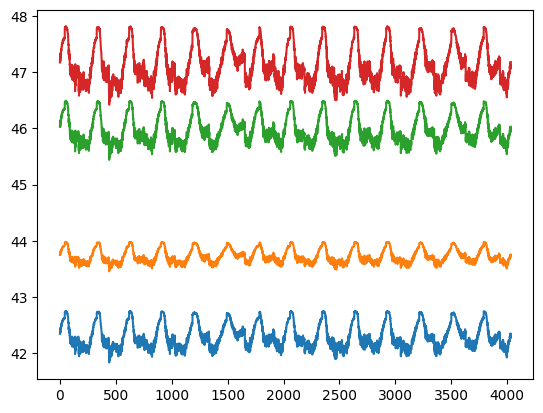

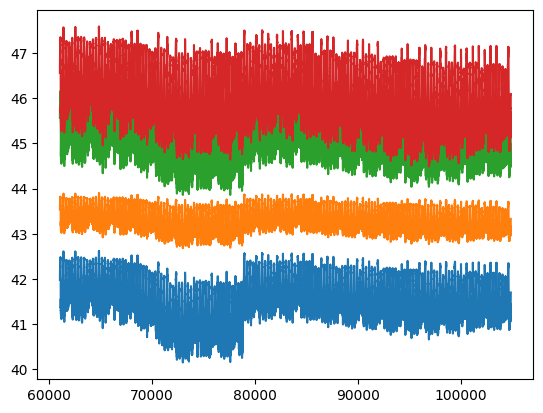

In [4]:
#Timeseries data (train) without anomalies
fig, ax = plt.subplots()
df_train.plot(legend=False, ax=ax)
plt.show()
#Timeseries data (test) with anomalies
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
plt.show()

Number of training samples: 4033


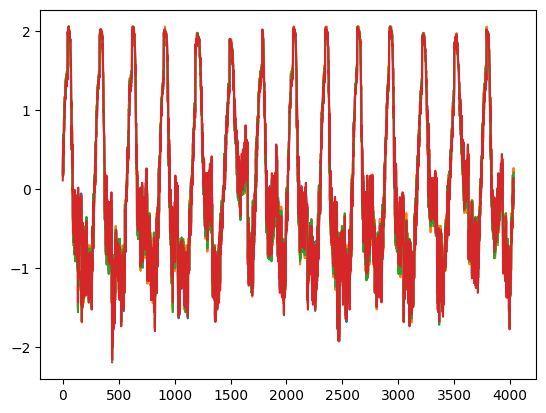

In [5]:
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
df_training_value=df_training_value.dropna()
print("Number of training samples:", len(df_training_value))
fig, ax = plt.subplots()
df_training_value.plot(legend=False, ax=ax)
plt.show()

In [6]:
TIME_STEPS = 288
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3746, 288, 4)


In [7]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=4,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=4,
            activation="tanh",
        ),
        layers.AveragePooling1D(pool_size=2),
        #last layer
        layers.Flatten(),
        layers.Dense(288 * len(sensor_list), activation='linear'),
        layers.Reshape((288, len(sensor_list)))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 288, 32)           928       
                                                                 
 average_pooling1d (Average  (None, 144, 32)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 144, 16)           3600      
                                                                 
 average_pooling1d_1 (Avera  (None, 72, 16)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_transpose (Conv1DTr  (None, 288, 16)           1808      
 anspose)                                                        
                                                      

Epoch 1/50

21/21 [==============================] - 2s 76ms/step - loss: 0.3110 - val_loss: 0.1272
Epoch 2/50
21/21 [==============================] - 1s 66ms/step - loss: 0.0962 - val_loss: 0.0732
Epoch 3/50
21/21 [==============================] - 1s 65ms/step - loss: 0.0690 - val_loss: 0.0557
Epoch 4/50
21/21 [==============================] - 1s 70ms/step - loss: 0.0511 - val_loss: 0.0415
Epoch 5/50
21/21 [==============================] - 1s 68ms/step - loss: 0.0429 - val_loss: 0.0351
Epoch 6/50
21/21 [==============================] - 3s 167ms/step - loss: 0.0383 - val_loss: 0.0316
Epoch 7/50
21/21 [==============================] - 5s 216ms/step - loss: 0.0358 - val_loss: 0.0296
Epoch 8/50
21/21 [==============================] - 4s 209ms/step - loss: 0.0340 - val_loss: 0.0279
Epoch 9/50
21/21 [==============================] - 4s 206ms/step - loss: 0.0324 - val_loss: 0.0265
Epoch 10/50
21/21 [==============================] - 4s 201ms/step - loss: 0.0310 - val_loss: 0.0254
Epo

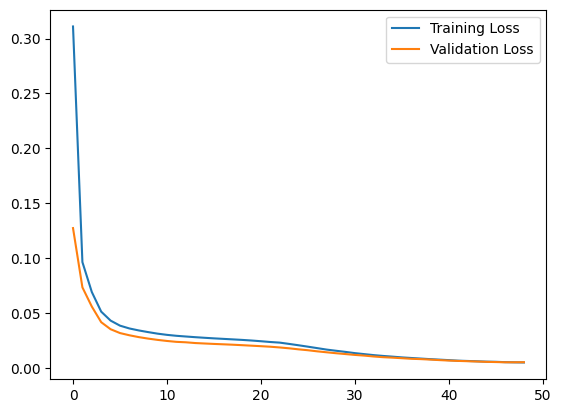

In [8]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=144,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss")# patience=5, mode="min"
    ],
)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 [==============================] - 1s 6ms/step


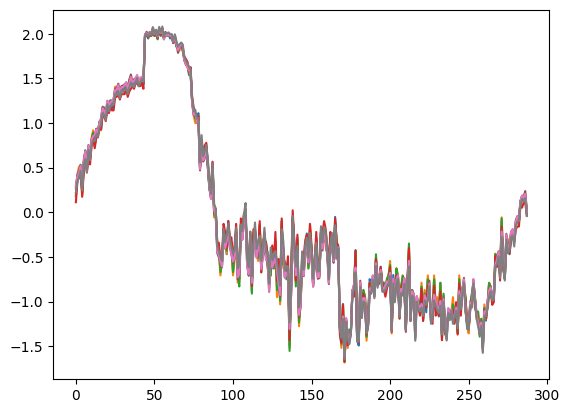

In [9]:
x_train_pred = model.predict(x_train)
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

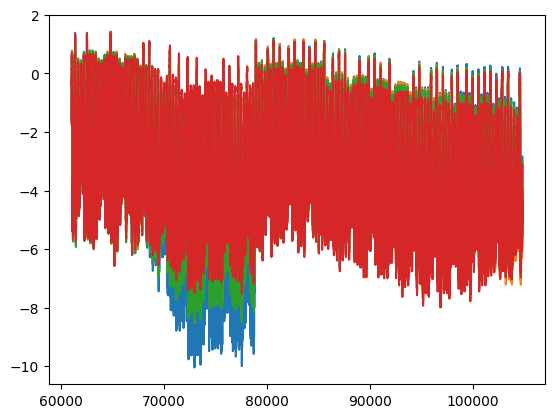

Test input shape:  (43489, 288, 4)


In [10]:
df_test_value = (df_test - training_mean) / training_std
df_test_value=df_test_value.dropna()
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

In [11]:
x_test_pred = model.predict(x_test)

1360/1360 [==============================] - 8s 6ms/step


In [12]:
def compute_score(x, x_rec):
    reconstruction_loss = np.abs(x - x_rec)
    ri = np.median(reconstruction_loss,axis=1) 
    r = np.median(ri)
    MAD = np.median(np.abs(ri - r))
    score = 0.6745 * np.abs(ri - r) / MAD
    return score

In [13]:
score_list=compute_score(x_test,x_test_pred)
print(score_list)

[[0.76534004 0.64782232 0.58473752 0.7072679 ]
 [0.75222139 0.60939666 0.59058544 0.66748387]
 [0.75882605 0.60860603 0.56975571 0.69416982]
 ...
 [0.35510166 1.11326932 0.71166587 0.69891448]
 [0.37441216 1.12367535 0.71558369 0.74851967]
 [0.32379665 1.08448675 0.68952363 0.64639458]]


In [16]:
threshold = 3.5 #default
# Label sequences based on anomaly score
labeled_events = np.where(score_list > threshold, "Loss Event", "Non-Lossy Event")
print("Labels:", labeled_events)


Labels: [['Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event']
 ['Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event']
 ['Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event']
 ...
 ['Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event']
 ['Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event']
 ['Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event' 'Non-Lossy Event']]


In [17]:
anomalies=score_list > threshold #just lossy events
print("Number of anomaly samples: ", np.sum(anomalies))

Number of anomaly samples:  5256


In [18]:
for i in range(anomalies.shape[1]):
    column_anomalies = anomalies[:, i]
    num_anomalies = np.sum(column_anomalies)
    anomaly_indices = np.where(column_anomalies)[0]
    print(f"Number of anomaly samples in column {i}: {num_anomalies}")
    # print(f"Indices of anomaly samples in column {i}: {anomaly_indices}")


Number of anomaly samples in column 0: 5256
Number of anomaly samples in column 1: 0
Number of anomaly samples in column 2: 0
Number of anomaly samples in column 3: 0


In [19]:
anomaly_indices_per_column = {}
# Iterate over the columns
for column in range(len(anomalies[0])):
    # Initialize an empty list to store anomaly indices for this column
    anomaly_indices_per_column[column] = []    
    # Iterate over the data indices
    for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
        # Check if the value in this column is an anomaly
        if anomalies[data_idx, column]:
            # Append the index to the list of anomaly indices for this column
            anomaly_indices_per_column[column].append(data_idx)

# Select subset of data containing only anomalous samples for each column
df_subset_per_column = {}
for column, indices in anomaly_indices_per_column.items():
    df_subset_per_column[column] = df_test_value.iloc[indices]

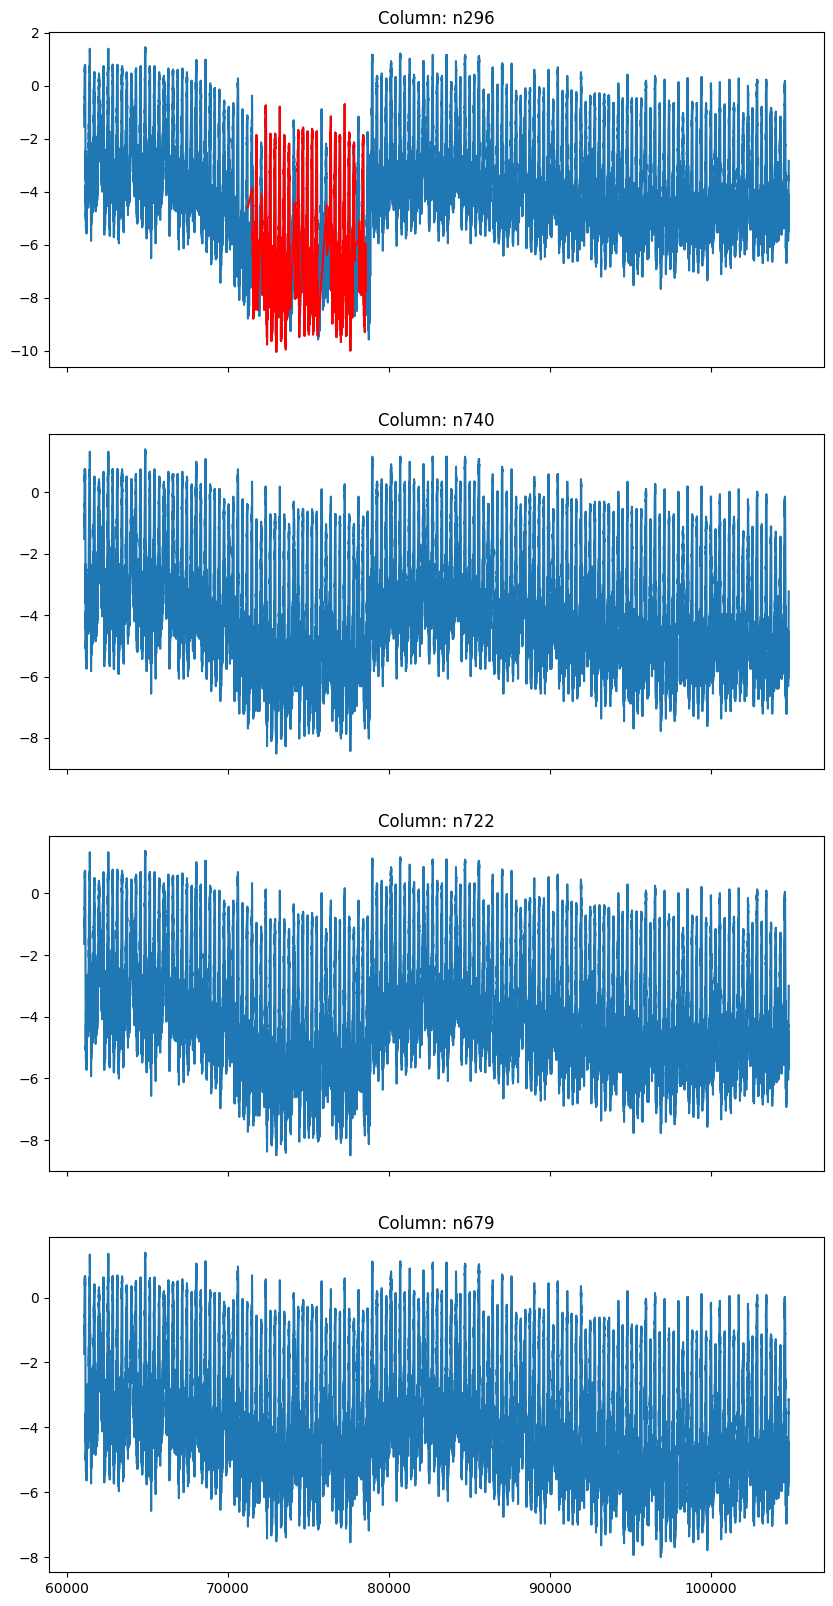

In [20]:
# Plot the original data and the subset of anomalous data for each column
fig, axes = plt.subplots(len(df_test_value.columns), 1, figsize=(10, 5 * len(df_test_value.columns)), sharex=True)
for i, column_name in enumerate(df_test_value.columns):
    ax = axes[i]
    df_test_value[column_name].plot(legend=False, ax=ax)
    df_subset_per_column[i][column_name].plot(legend=False, ax=ax, color="r")
    ax.set_title(f"Column: {column_name}")
plt.show()